In [1]:
# generating Minimum Snap trajectories as a benchmark for the G&CNets
import matplotlib.pyplot as plt
import numpy as np
from sympy import *

# plt.rcParams.update({
#     'text.usetex': True,
#     'font.family': 'Lucida'
# })

# Position and yaw are described by nth order polynomials
t = Symbol('t')

# Degree of polynomials
n=6

# number of laps
n_laps = 10

# number of trajectories
n_traj = 4*n_laps

parameters = [Matrix([['p'+str(i)+str(j)+str(k) for j in range(n+1)] for k in range(4)]) for i in range(n_traj)]
T = [Symbol('T'+str(i)) for i in range(4*n_laps)]

def get_traj(idx):
    P = parameters[idx]
    x   = sum([P[0,i]*t**i for i in range(n+1)])
    y   = sum([P[1,i]*t**i for i in range(n+1)])
    z   = sum([P[2,i]*t**i for i in range(n+1)])
    psi = sum([P[3,i]*t**i for i in range(n+1)])
    return x,y,z,psi

In [2]:
# Objective function
kr = 4
kpsi = 2

# pos and yaw have equal weight
mur = 1
mupsi = 1

def get_Obj(idx):
    x,y,z,psi = get_traj(idx)
    return integrate(mur*(diff(x,t,kr)**2+diff(y,t,kr)**2+diff(z,t,kr)**2) + mupsi*(diff(psi,t,kpsi)**2), (t, 0, T[idx]))

Obj = sum(get_Obj(i) for i in range(n_traj))

In [3]:
# Waypoints

d=np.sin(np.pi/4)

wp1 = np.array([4,0,0]) + 0.2*np.array([-d,d,0])
wp2 = np.array([4,3,0]) + 0.2*np.array([-d,-d,0])
wp3 = np.array([0,3,0]) + 0.2*np.array([d,-d,0])
wp4 = np.array([0,0,0]) + 0.2*np.array([d,d,0])

waypoints = np.array([
    [wp1[0],wp2[0],wp3[0],wp4[0]]*n_laps,
    [wp1[1],wp2[1],wp3[1],wp4[1]]*n_laps,
    [0,0,0,0]*n_laps,
    [np.pi/4+i*np.pi/2 for i in range(4*n_laps)]
]).T



# Waypoints -20cm
# waypoints = np.array([
#     [4,4,0,0]*n_laps,
#     [0,3,3,0]*n_laps,
#     [0,0,0,0]*n_laps,
#     [np.pi/4+i*np.pi/2 for i in range(4*n_laps)]
# ]).T

# Waypoints figure 8
# waypoints = np.array([
#     [4,0,4,0]*n_laps,
#     [0,3,3,0]*n_laps,
#     [0,0,0,0]*n_laps,
#     [0,0,0,0]*n_laps
# ]).T

In [4]:
# Get constraints of the ith trajectory
def get_constraints(idx):
    x,y,z,psi = get_traj(idx)
    
    # Equality constraints g(p) = 0
    g=[]
    
    if idx==0:
        # Initial state (hover)
        for i in range(3):
            g.append(diff(x,t,i).subs(t,0))
            g.append(diff(y,t,i).subs(t,0))
            g.append(diff(z,t,i).subs(t,0))
            g.append(diff(psi,t,i).subs(t,0))
    else:
        # Enforce continuity of the first kr derivatives of rT and first kψ derivatives of ψT
        x_,y_,z_,psi_ = get_traj(idx-1)
        for i in range(kr+1):
            g.append(diff(x_,t,i).subs(t,T[idx-1])-diff(x,t,i).subs(t,0))
            g.append(diff(y_,t,i).subs(t,T[idx-1])-diff(y,t,i).subs(t,0))
            g.append(diff(z_,t,i).subs(t,T[idx-1])-diff(z,t,i).subs(t,0))
        for i in range(kpsi+1):
            g.append(diff(psi_,t,i).subs(t,T[idx-1])-diff(psi,t,i).subs(t,0))
    
    # Waypoint Constraints
    xT,yT,zT,psiT = waypoints[idx]
    g.append(x.subs(t,T[idx])-xT)
    g.append(y.subs(t,T[idx])-yT)
    g.append(z.subs(t,T[idx])-zT)
    g.append(psi.subs(t,T[idx])-psiT)
    
    # Velocity Constraints
    g.append(sin(psiT)*diff(x,t).subs(t,T[idx])-cos(psiT)*diff(y,t).subs(t,T[idx]))
    g.append(diff(z,t).subs(t,T[idx]))
    return g

In [5]:
from amplpy import AMPL

ampl = AMPL()
ampl.eval('option solver snopt;')

ampl.eval('param Tn default '+ str(n_traj) + ';')

# VARIABLES
for t_ in T:
    ampl.eval('var ' + str(t_) + ', >= 0;')
for P in parameters:
    for p in P:
        ampl.eval('var ' + str(p) + ';')

# OBJECTIVE
objective = str(Obj)
objective = objective.replace('**','^')
ampl.eval('minimize myobjective: '+str(objective) +';')

# CONSTRAINTS
ampl.eval('subject to time_constraint: '+str(sum(T))+'=Tn;')

for idx in range(n_traj):
    ampl.eval('subject to time_constraint' + str(idx) + ':' + str(T[idx]) + '= 1.;')

# ADD CONSTRAINTS FOR EACH TRAJ
for idx in range(n_traj):
    g = get_constraints(idx)
    for i in range(len(g)):
        constraint = str(g[i])
        constraint = constraint.replace('**','^')
        ampl.eval('subject to constraint' + str(idx) + '_' + str(i) + ':' + str(constraint) + '=0;')

# SOLVE
ampl.solve()
    
# REMOVE TIME CONSTRIANTS
for idx in range(n_traj):
    ampl.getConstraint('time_constraint'+str(idx)).drop()


ampl.solve()

SNOPT 7.2-4 SNOPT 7.2-4 : Optimal solution found.
727 iterations, objective 225567.55
SNOPT 7.2-4 SNOPT 7.2-4 : Optimal solution found.
1184 iterations, objective 8901.731799
Nonlin evals: obj = 887, grad = 886, constrs = 887, Jac = 886.


In [6]:
# SOLVE AGAIN?
ampl.solve()

SNOPT 7.2-4 : SNOPT 7.2-4 : Optimal solution found.
1 iterations, objective 8901.731799
Nonlin evals: obj = 2, grad = 1, constrs = 2, Jac = 1.


In [7]:
def get_traj_solved(idx):
    x,y,z,psi = get_traj(idx)
    x   = x.subs([(str(p), ampl.getVariable(str(p)).value()) for p in parameters[idx]])
    y   = y.subs([(str(p), ampl.getVariable(str(p)).value()) for p in parameters[idx]])
    z   = z.subs([(str(p), ampl.getVariable(str(p)).value()) for p in parameters[idx]])
    psi = psi.subs([(str(p), ampl.getVariable(str(p)).value()) for p in parameters[idx]])
    return x,y,z,psi

In [8]:
x,y,z,psi =[],[],[],[]
T_ = np.cumsum([0] + [ampl.getVariable(str(T[i])).value() for i in range(n_traj)])
for i in range(n_traj):
    xi,yi,zi,psii = get_traj_solved(i)
    x.append((xi.subs(t,t-T_[i]),(t>=T_[i])&(t<T_[i+1])))
    y.append((yi.subs(t,t-T_[i]),(t>=T_[i])&(t<T_[i+1])))
    z.append((zi.subs(t,t-T_[i]),(t>=T_[i])&(t<T_[i+1])))
    psi.append((psii.subs(t,t-T_[i]),(t>=T_[i])&(t<T_[i+1])))

x.append((waypoints[-1][0], True))
y.append((waypoints[-1][1], True))
z.append((waypoints[-1][2], True))
psi.append((waypoints[-1][3], True))

x   = Piecewise(*x, evaluate=False)
y   = Piecewise(*y, evaluate=False)
z   = Piecewise(*z, evaluate=False)
psi = Piecewise(*psi, evaluate=False)
print(T_[16])

16.72381147516692


In [9]:
import matplotlib as mpl
import matplotlib.cm as cm

norm = mpl.colors.Normalize(0,7)
cmap = cm.jet 

def color_plot(x_axis,y_axis,color_axis,step=1):
    for i in reversed(range(step,len(x_axis),step)):
        ax = plt.gca()
        ax.plot([x_axis[i-step], x_axis[i]],[y_axis[i-step], y_axis[i]], color=cmap(norm(color_axis[i])))
        ax.axis('equal')
        
def color_plot3D(x_axis,y_axis,z_axis,color_axis,step=1):
    ax = plt.axes(projection='3d')
    for i in reversed(range(step,len(x_axis),step)):
        ax.plot3D([x_axis[i-step], x_axis[i]],[y_axis[i-step], y_axis[i]],[z_axis[i-step], z_axis[i]], color=cmap(norm(color_axis[i])))
#         ax.axis('equal')

/tmp/ipykernel_2612011/2797932967.py:17: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.gcf().colorbar(cm.ScalarMappable(norm=norm, cmap=cmap))


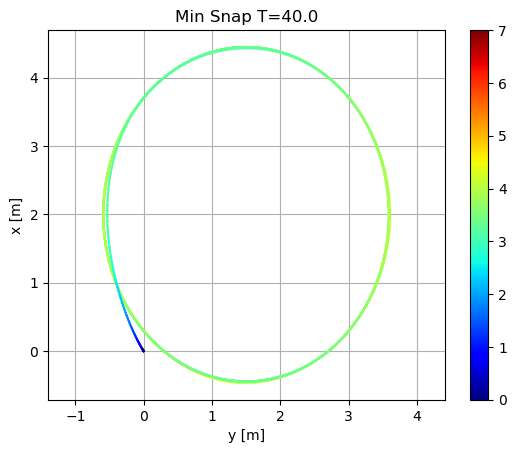

In [10]:
vx = diff(x,t)
vy = diff(y,t)
V = sqrt(vx**2+vy**2)

t_ = np.linspace(0,T_[-1],1600)
x_ = lambdify(t,x)
y_ = lambdify(t,y)
z_ = lambdify(t,z)
psi_ = lambdify(t,psi)
V_ = lambdify(t,V)

color_plot(y_(t_),x_(t_),V_(t_))
plt.xlabel('y [m]')
plt.ylabel('x [m]')
plt.grid()
plt.gca().axis('equal')
plt.gcf().colorbar(cm.ScalarMappable(norm=norm, cmap=cmap))
plt.title('Min Snap T=40.0')
plt.show()

/tmp/ipykernel_2612011/1038198607.py:10: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.gcf().colorbar(cm.ScalarMappable(norm=norm, cmap=cmap))


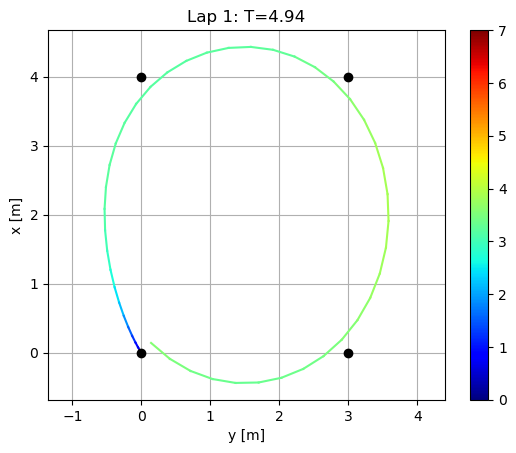

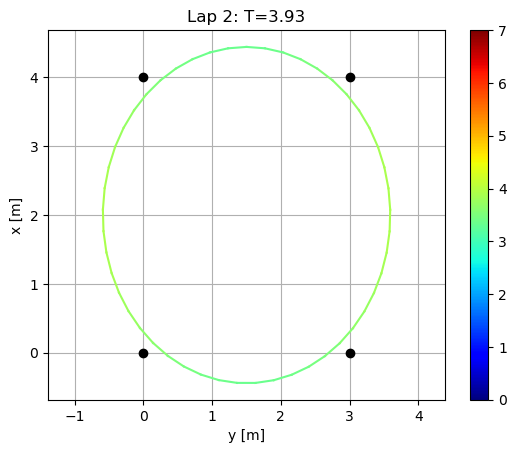

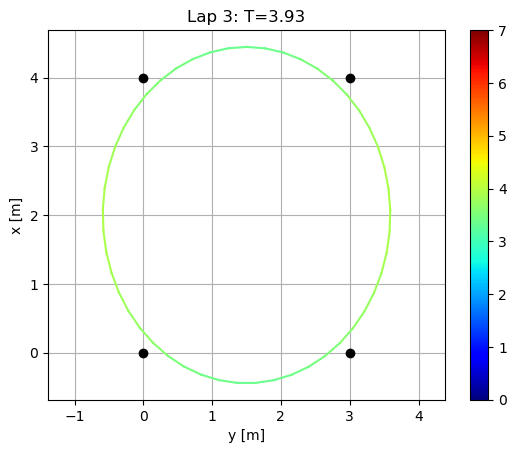

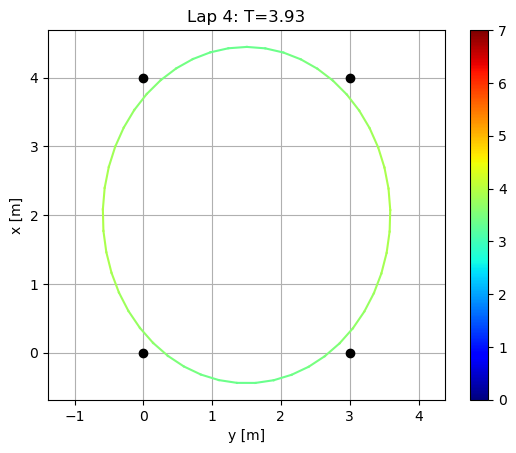

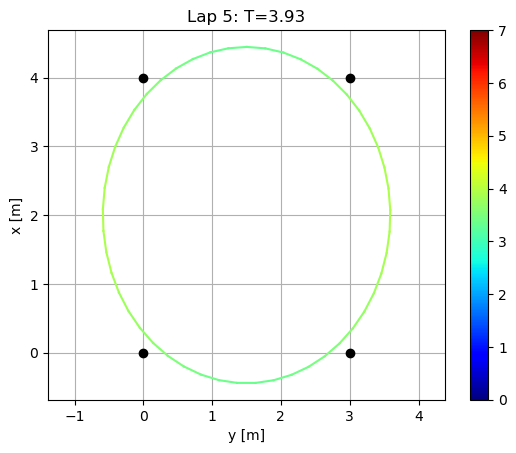

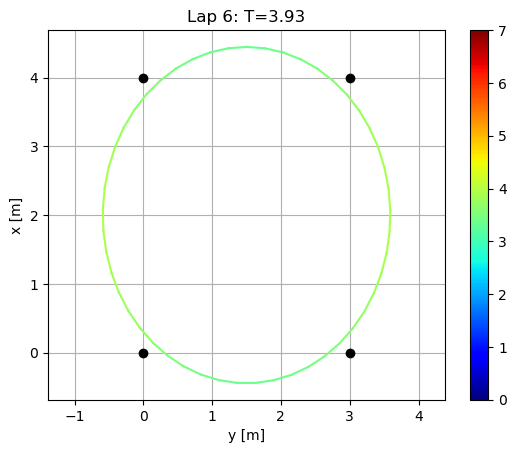

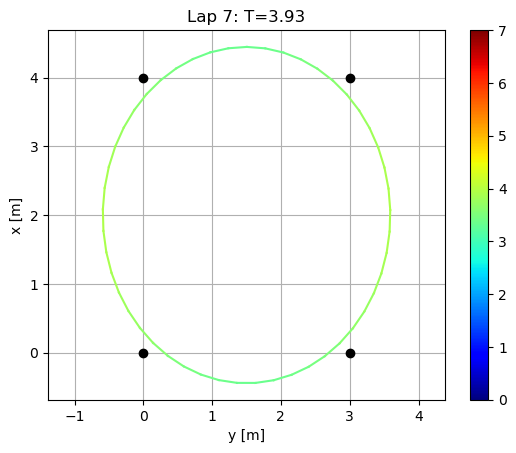

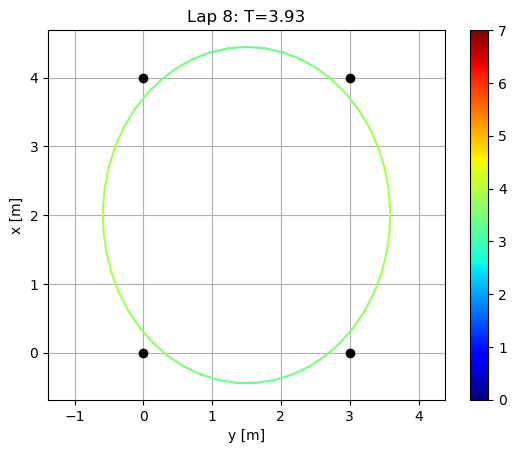

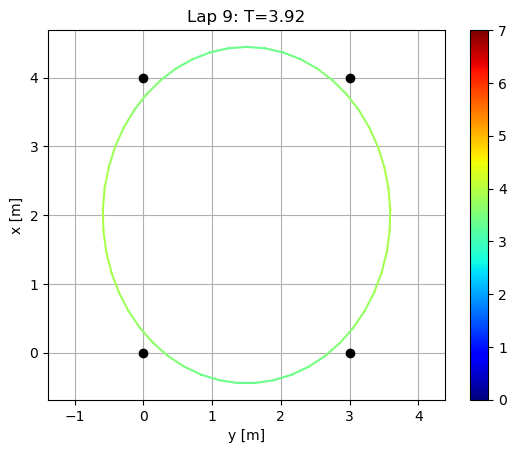

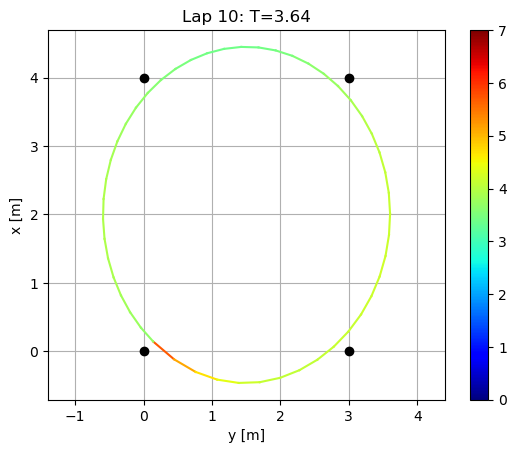

In [11]:
%matplotlib inline
for i in range(n_laps):
    ti = np.linspace(T_[i*4],T_[i*4+4])
    color_plot(y_(ti),x_(ti),V_(ti))
    plt.scatter([0,0,3,3],[0,4,4,0],c='black',zorder=3)
    plt.xlabel('y [m]')
    plt.ylabel('x [m]')
    plt.grid()
    plt.gca().axis('equal')
    plt.gcf().colorbar(cm.ScalarMappable(norm=norm, cmap=cmap))
    plt.title('Lap ' + str(i+1) +': T=' + str(round(T_[i*4+4]-T_[i*4],2)))
    plt.savefig('Figures/MinSnapLap'+str(i+1)+'.png')
    plt.show()

In [13]:
print(T_[::4])
vx = diff(x,t)
vy = diff(y,t)
vx_ = lambdify(t,vx)
vy_ = lambdify(t,vy)

for i in range(n_laps):
    print('Lap '+str(i))
    print('vx0='+str(vx_(T_[4*i]))+',vxT='+str(vx_(T_[4*i+4])))
    print('vy0='+str(vy_(T_[4*i]))+',vyT='+str(vy_(T_[4*i+4])))

[ 0.          4.93905259  8.86924671 12.79655173 16.72381148 20.65107023
 24.57832899 28.5055868  32.43280107 36.35712583 40.        ]
Lap 0
vx0=0.0,vxT=2.5300867025896494
vy0=0.0,vyT=-2.5300867025893403
Lap 1
vx0=2.5300867025896494,vxT=2.5414849565147932
vy0=-2.5300867025893403,vyT=-2.5414849565150384
Lap 2
vx0=2.5414849565147932,vxT=2.54171748326646
vy0=-2.5414849565150384,vyT=-2.541717483266858
Lap 3
vx0=2.54171748326646,vxT=2.5417232402947008
vy0=-2.541717483266858,vyT=-2.541723240295113
Lap 4
vx0=2.5417232402947008,vxT=2.5417234114333667
vy0=-2.541723240295113,vyT=-2.5417234114337077
Lap 5
vx0=2.5417234114333667,vxT=2.541723421161109
vy0=-2.5417234114337077,vyT=-2.5417234211616204
Lap 6
vx0=2.541723421161109,vxT=2.5417292067533026
vy0=-2.5417234211616204,vyT=-2.5417292067529615
Lap 7
vx0=2.5417292067533026,vxT=2.541954623033064
vy0=-2.5417292067529615,vyT=-2.541954623033334
Lap 8
vx0=2.541954623033064,vxT=2.553460192824531
vy0=-2.541954623033334,vyT=-2.5534601928245735
Lap 9
vx0=2

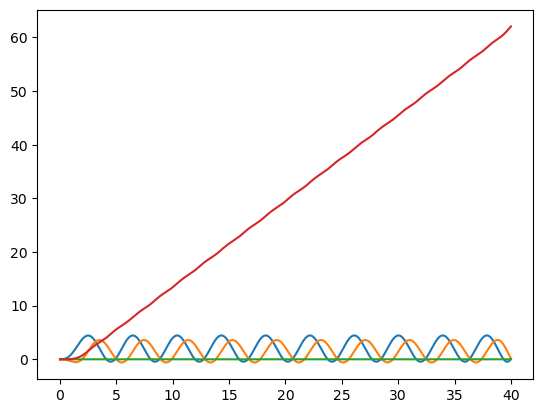

In [22]:
plt.plot(t_, x_(t_), label='x')
plt.plot(t_, y_(t_))
plt.plot(t_, z_(t_))
plt.plot(t_, psi_(t_))

In [23]:
%matplotlib
# ax = plt.axes(projection='3d')
color_plot3D(y_(t_),x_(t_),-z_(t_),V_(t_))
wpx = waypoints[0:4][:,0]
wpy = waypoints[0:4][:,1]
wpz = waypoints[0:4][:,2]
plt.gca().scatter3D(wpy,wpx,-wpz,color='black')
plt.gca().set_aspect('equal') 
plt.show()

Using matplotlib backend: <object object at 0x7f85281bfba0>


In [24]:
lap_times = T_[4::4]-T_[:-4:4]

alpha = np.arange(0.7,1.5,0.05)
table = np.zeros([3, len(alpha)])

for i in range(len(alpha)):
    table[0,i] = alpha[i]
    table[1,i] = T_[16]/alpha[i]
    table[2,i] = T_[-1]/alpha[i]

for i in range(len(alpha)):
    print('|c',end='')
print('|')

for row in table:
    for i in row:
        print(f"{i:.2f}", end='&')
    print('\\'*2)
#     print(f"{a:.2f}",'&',f"{(T_[16]/a):.2f}", '&', f"{(T_[-1]/a):.2f}", '\\'*2)

|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|
0.70&0.75&0.80&0.85&0.90&0.95&1.00&1.05&1.10&1.15&1.20&1.25&1.30&1.35&1.40&1.45&\\
23.89&22.30&20.90&19.68&18.58&17.60&16.72&15.93&15.20&14.54&13.94&13.38&12.86&12.39&11.95&11.53&\\
57.14&53.33&50.00&47.06&44.44&42.11&40.00&38.10&36.36&34.78&33.33&32.00&30.77&29.63&28.57&27.59&\\


In [25]:
z=simplify(z)
psi=simplify(psi)

## Generate C code

In [26]:
from sympy.utilities.codegen import codegen

# TRANSFORM TO CYBERZOO COORDINATES
x_ = x-2.
y_ = y-1.5
z_ = z-1.

angle = -33*np.pi/180
x_new = x_*cos(angle) - y_*sin(angle)
y_new = x_*sin(angle) + y_*cos(angle)
x_ = x_new
y_ = y_new
psi_ = psi + angle

# TIME SCALE PARAMETER
alpha = Symbol('alpha')
x_ = x_.subs(t,alpha*t)
y_ = y_.subs(t,alpha*t)
z_ = z_.subs(t,alpha*t)
psi_ = psi_.subs(t,alpha*t)

vx_ = diff(x_,t)
vy_ = diff(y_,t)
vz_ = diff(z_,t)

ax_ = diff(vx_,t)
ay_ = diff(vy_,t)
az_ = diff(vz_,t)

print('generating code')
[(c_name, c_code), (h_name, c_header)] = codegen([
    ("get_x", x_),
    ("get_y", y_),
    ("get_z", z_),
    ("get_psi", psi_),
    ("get_vx", vx_),
    ("get_vy", vy_),
    ("get_vz", vz_),
    ("get_ax", ax_),
    ("get_ay", ay_),
    ("get_az", az_)
], "C", "min_snap", header=True, empty=False)

generating code


In [27]:
c_header = c_header.replace('int', 'double')
c_header = c_header.replace('()', '(double alpha, double t)')
# print(c_header)

In [28]:
c_code = c_code.replace('int', 'double')
c_code = c_code.replace('()', '(double alpha, double t)')
# print(c_code)

In [29]:
text_file = open('c_code/'+c_name, "w")
n = text_file.write(c_code)
text_file.close()

text_file = open('c_code/'+h_name, "w")
n = text_file.write(c_header)
text_file.close()

In [30]:
print("cyberzoo waypoint coordinates:")
for i in range(-1,3):
    wpx,wpy = waypoints[i][0:2]
    wpx -= 2
    wpy -= 1.5
    wpx_new = wpx*cos(angle) - wpy*sin(angle)
    wpy_new = wpx*sin(angle) + wpy*cos(angle)
    print('ENU wp'+str((i+1)%4+1), round(wpy_new,2), round(wpx_new,2), 1)

print('')

print("flight plan waypoint definition:")
for i in range(-1,3):
    wpx,wpy = waypoints[i][0:2]
    wpx -= 2
    wpy -= 1.5
    wpx_new = wpx*cos(angle) - wpy*sin(angle)
    wpy_new = wpx*sin(angle) + wpy*cos(angle)
    print('<waypoint name="WP'+str((i+1)%4+1)+'" x="'+str(round(wpy_new,3))+'" y="'+str(round(wpx_new,3))+'" alt="1."/>')

cyberzoo waypoint coordinates:
ENU wp1 -0.13 -2.30 1
ENU wp2 -2.15 0.82 1
ENU wp3 0.13 2.30 1
ENU wp4 2.15 -0.82 1

flight plan waypoint definition:
<waypoint name="WP1" x="-0.127" y="-2.299" alt="1."/>
<waypoint name="WP2" x="-2.152" y="0.819" alt="1."/>
<waypoint name="WP3" x="0.127" y="2.299" alt="1."/>
<waypoint name="WP4" x="2.152" y="-0.819" alt="1."/>


## Test C code

In [31]:
import subprocess
import ctypes
import os

path = os.path.abspath('c_code')

# https://cu7ious.medium.com/how-to-use-dynamic-libraries-in-c-46a0f9b98270

# Create object files
print('Create object files')
subprocess.call('gcc -fPIC -c *.c', shell=True, cwd=path)

# Create library
print('Create library')
subprocess.call('gcc -shared -Wl,-soname,libtools.so -o libtools.so *.o', shell=True, cwd=path)

# Remove object files
subprocess.call('rm *.o', shell=True, cwd=path)

Create object files
Create library


0

In [32]:
lib_path = os.path.abspath("c_code/libtools.so")
fun = ctypes.CDLL(lib_path)

In [33]:
fun.get_x.argtypes = [ctypes.c_double, ctypes.c_double]
fun.get_x.restype = ctypes.c_double

fun.get_y.argtypes = [ctypes.c_double, ctypes.c_double]
fun.get_y.restype = ctypes.c_double

fun.get_z.argtypes = [ctypes.c_double, ctypes.c_double]
fun.get_z.restype = ctypes.c_double

In [34]:
x__ = [fun.get_x(1,ti) for ti in t_]
y__ = [fun.get_y(1,ti) for ti in t_]
z__ = [fun.get_z(1,ti) for ti in t_]

In [36]:
%matplotlib
ax = plt.axes(projection='3d')
ax.plot3D(x__,y__,z__)
plt.show()

Using matplotlib backend: QtAgg


## Check feasibility

In [19]:
# Check feasability
def getThrustMoment(x_s,y_s,z_s,psi_s):
    # Calculate Thrust and Moment based on the trajectory
    # following equations 7-19 from https://arxiv.org/pdf/1712.02402.pdf
    
    g_=9.81
    dx=dy=dz=0.5
    I=np.diag([0.00090600,0.00124200,0.00205400])
    
    # velocity
    v = np.array([diff(x_s,t),diff(y_s,t), diff(z_s,t)])
    # acceleration
    a = np.array([diff(v[0],t),diff(v[1],t),diff(v[2],t)])
    # jerk
    j = np.array([diff(a[0],t),diff(a[1],t),diff(a[2],t)])
    # world z-axis
    zw = np.array([0,0,1])

    # Calculate body axes
    alpha = a + g_*zw + dx*v
    beta = a + g_*zw + dy*v
    xc = np.array([cos(psi_s), sin(psi_s), 0])
    yc = np.array([-sin(psi_s), cos(psi_s), 0])

    xb = np.cross(yc,alpha)
    xb = xb/sqrt(xb@xb)

    yb = np.cross(beta,xb)
    yb = yb/sqrt(yb@yb)

    zb = np.cross(xb,yb)

    # Calculate (mass normalized) Thrust
    c = zb@(a+g_*zw+dz*v)

    # Calculate Body rates
    wz = yb@[diff(xb[i],t) for i in range(3)]
    wy = (xb@j+dx*xb@a + wz*(dx-dy)*(yb@v))/(c-(dz-dx)*(zb@v))
    wx = (-yb@j-dy*yb@a - wz*(dx-dy)*(xb@v))/(c+(dy-dz)*(zb@v))

    omega = np.array([wx,wy,wz])

    # # Calculate Moments
    M = I@[diff(omega[i], t) for i in range(3)] + np.cross(omega,I@omega)
    return c,M


def checkFeasible(x_s,y_s,z_s,psi_s,T_s):
    c, M = getThrustMoment(x_s,y_s,z_s,psi_s)
        
    omega_min = 3000
    omega_max = 12000

    k_w = 4.36301076e-08
    k_p = 1.41193310e-09
    k_q = 1.21601884e-09
    k_r = 2e-10 #guess

    Mat = np.array([
        [k_w,k_w,k_w,k_w],
        [k_p,-k_p,-k_p,k_p],
        [k_q,k_q,-k_q,-k_q],
        [-k_r,k_r,-k_r,k_r]
    ])

    Mat_inv = np.linalg.inv(Mat)

    t_ = np.linspace(0,T_s,100)
    for ti in t_:
        ci = c.subs(t,ti)
        Mi = [M[0].subs(t,ti), M[1].subs(t,ti), M[2].subs(t,ti)]

        # solve for rpms
        w = Mat_inv@np.array([ci, Mi[0], Mi[1], Mi[2]], dtype='float')
        w = np.sqrt(w)
        for wi in w:
            if not (3000<wi<12000):
                return False
    return True

In [20]:
Tf = T_[-1]
print('Tf='+str(Tf))
Tmin = 14
Tmax = 15

while Tmax-Tmin>0.001:
    Ts=(Tmin+Tmax)/2
    print('T='+str(Ts))
    alpha = Tf/Ts
    
    xs = x.subs(t, alpha*t)
    ys = y.subs(t, alpha*t)
    zs = z.subs(t, alpha*t)
    psis = psi.subs(t, alpha*t)
    
    if checkFeasible(xs,ys,zs,psis,Ts):
        print('Feasible!')
        Tmax = Ts
    else:
        print('Infeasible!')
        Tmin = Ts
    

print('Fastest feasible solution found:')
print('T=' + str(Tmax))
# Final solution
xs = x.subs(t, t/Ts)
ys = y.subs(t, t/Ts)
zs = z.subs(t, t/Ts)
psis =  psi.subs(t, t/Ts)

Tf=15.999999999999813
T=14.5
Feasible!
T=14.25
Infeasible!
T=14.375
Feasible!
T=14.3125
Feasible!
T=14.28125
Infeasible!
T=14.296875
Feasible!
T=14.2890625
Infeasible!
T=14.29296875
Feasible!
T=14.291015625
Feasible!
T=14.2900390625
Feasible!
Fastest feasible solution found:
T=14.2900390625


In [12]:
traj = {'t':tn, 'x':xn-2, 'y':yn-1.5, 'V':Vn}
np.savez_compressed('simulation_data/min_snap', **traj)